In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import numpy as np
import seaborn as sns
from tabulate import tabulate

from collections import Counter

repos_2019 = pd.read_json('repos_2019.json')
repos_2020 = pd.read_json('repos_2020.json')
repos_2021 = pd.read_json('repos_2021.json')
repos_2022 = pd.read_json('repos_2022.json')
repos_2023 = pd.read_json('repos_2023.json')

In [2]:
years_dataframes = [
    ('2019', repos_2019),
    ('2020', repos_2020),
    ('2021', repos_2021),
    ('2022', repos_2022),
    ('2023', repos_2023)
]

In [3]:
for year, dataframe in years_dataframes:
    print(f"Number of repositories in {year}: {len(dataframe)}")

Number of repositories in 2019: 34232
Number of repositories in 2020: 33191
Number of repositories in 2021: 24990
Number of repositories in 2022: 19910
Number of repositories in 2023: 15416


In [4]:
def calculate_repos_with_star_thresholds(repos_list, stars_thresholds=[100, 1000, 5000, 25000]):
    """
    Calculate and print the total number of repositories and the number of repositories
    with stars greater than the specified thresholds.

    Args:
    repos_list (list of DataFrame): List of DataFrames containing repository data.
    stars_thresholds (list of int): List of star thresholds to calculate totals for.
    """
    # Calculate the total number of repositories
    total_repos = sum([len(repos) for repos in repos_list])
    print(f"Total number of repositories: {total_repos}")

    # Calculate the total number of repositories with stars greater than the specified thresholds
    for threshold in stars_thresholds:
        total_repos_threshold = sum([len(repos[repos['stargazers_count'] > threshold]) for repos in repos_list])
        print(f"Total number of repositories with stars > {threshold}: {total_repos_threshold}")

calculate_repos_with_star_thresholds([repos_2019, repos_2020, repos_2021, repos_2022, repos_2023])

Total number of repositories: 127739
Total number of repositories with stars > 100: 127739
Total number of repositories with stars > 1000: 12960
Total number of repositories with stars > 5000: 1982
Total number of repositories with stars > 25000: 184


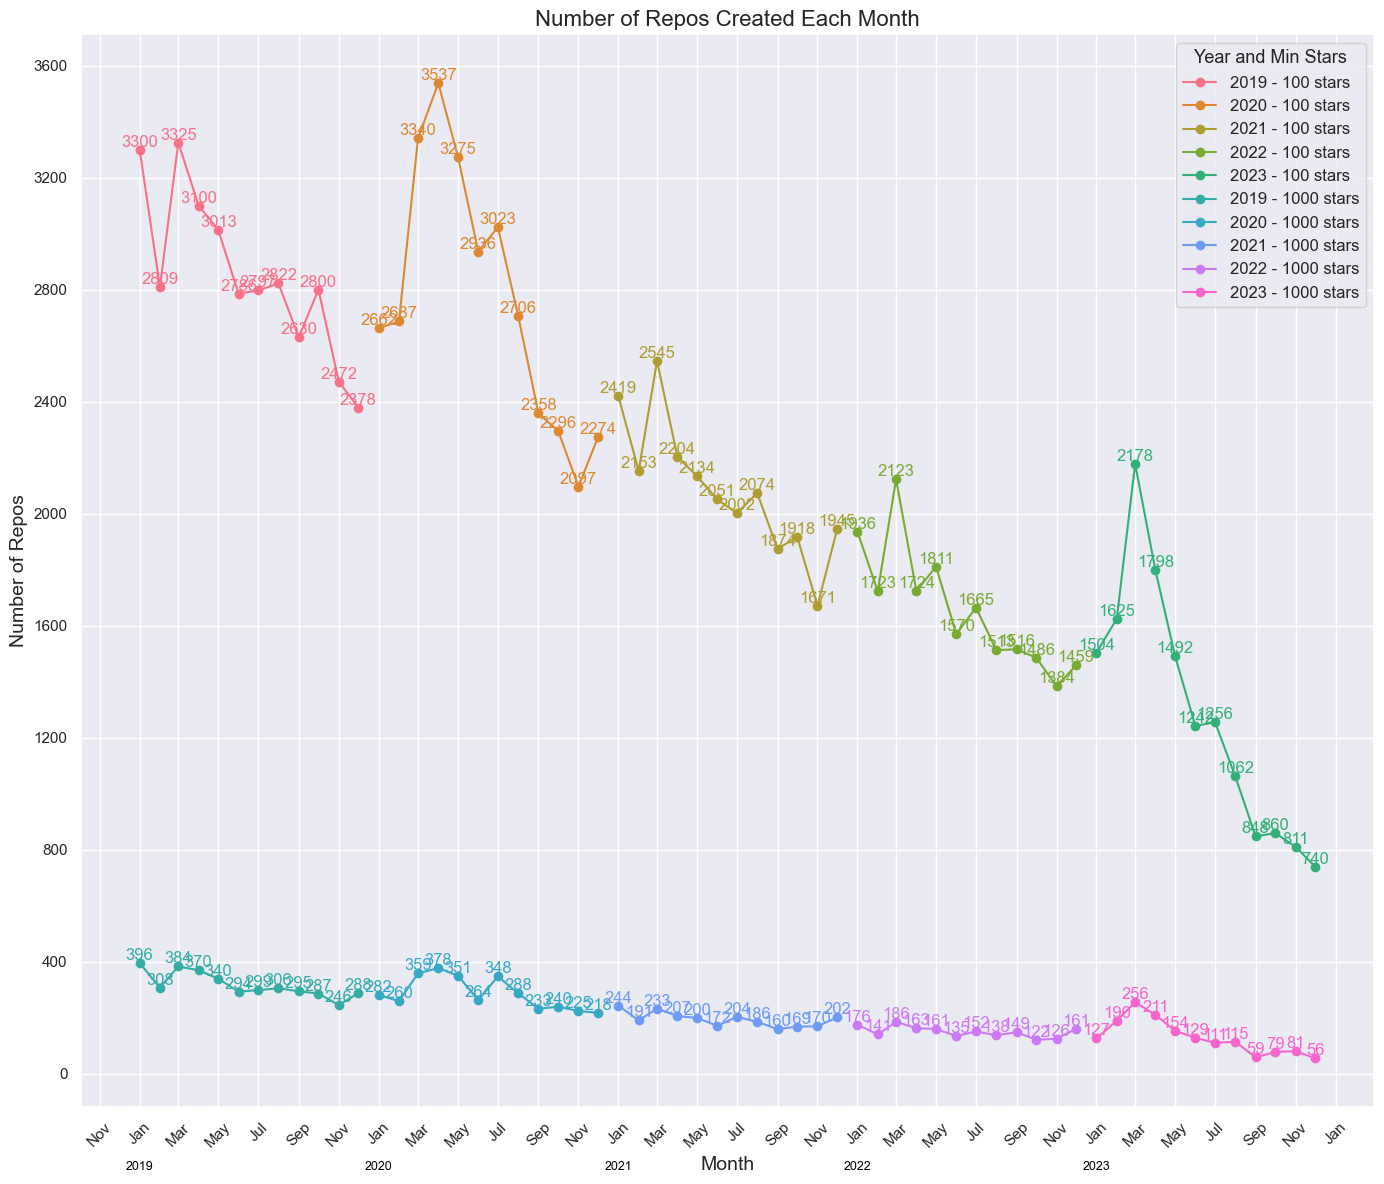

In [5]:
def plot_monthly_repo_creation(repos_dfs, years, min_stars_list=[None]):
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(14, 12))

    # Create a color palette with enough colors for each min_stars value per year
    colors = sns.color_palette("husl", len(repos_dfs) * len(min_stars_list))

    for min_stars in min_stars_list:
        for repos_df, year in zip(repos_dfs, years):
            # Filter the DataFrame if a minimum stars threshold is specified
            if min_stars is not None:
                filtered_repos_df = repos_df[repos_df['stargazers_count'] >= min_stars].copy()
            else:
                filtered_repos_df = repos_df.copy()

            filtered_repos_df['created_at'] = pd.to_datetime(filtered_repos_df['created_at']).dt.tz_localize(None)
            monthly_counts = filtered_repos_df.groupby(filtered_repos_df['created_at'].dt.to_period('M')).size()

            # Calculate the color index based on the year and min_stars index
            color_index = years.index(year) + min_stars_list.index(min_stars) * len(years)
            plt.plot(monthly_counts.index.to_timestamp(), monthly_counts.values, label=f'{year} - {min_stars} stars' if min_stars else f'{year}', color=colors[color_index], marker='o', linestyle='-')

            for month, count in zip(monthly_counts.index, monthly_counts.values):
                plt.text(month.to_timestamp(), count, str(count), ha='center', va='bottom', color=colors[color_index])

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1, 13, 2)))  # Display every other month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.xticks(rotation=45)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Annotate the year under January
    for year in years:
        january = pd.Timestamp(year=year, month=1, day=1)
        # Set the y-coordinate to be slightly below the x-axis line
        plt.text(january, ax.get_ylim()[0] - (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.05, str(year), ha='center', va='top', color='black', fontsize=9)

    plt.title('Number of Repos Created Each Month', fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Number of Repos', fontsize=14)
    plt.legend(fontsize=12, title="Year and Min Stars", title_fontsize='13')
    plt.tight_layout()
    plt.show()


plot_monthly_repo_creation([repos_2019, repos_2020, repos_2021, repos_2022, repos_2023], [2019, 2020, 2021, 2022, 2023], min_stars_list=[100, 1000])


In [6]:
def check_for_duplicates(repos_df):
    """
    Checks if there are any duplicate repositories in the DataFrame.
    
    Args:
    repos (DataFrame): DataFrame containing repository data.
    
    Returns:
    bool: True if duplicates exist, False otherwise.
    """
    # Check for duplicate repository names in the DataFrame
    if repos_df['name'].duplicated().any():
        return True
    
    # If we reach this point, there are no duplicates
    return False

In [7]:
duplicate_exists = any(check_for_duplicates(repos_df) for repos_df in [repos_2019, repos_2020, repos_2021, repos_2022, repos_2023])
print(duplicate_exists)

False


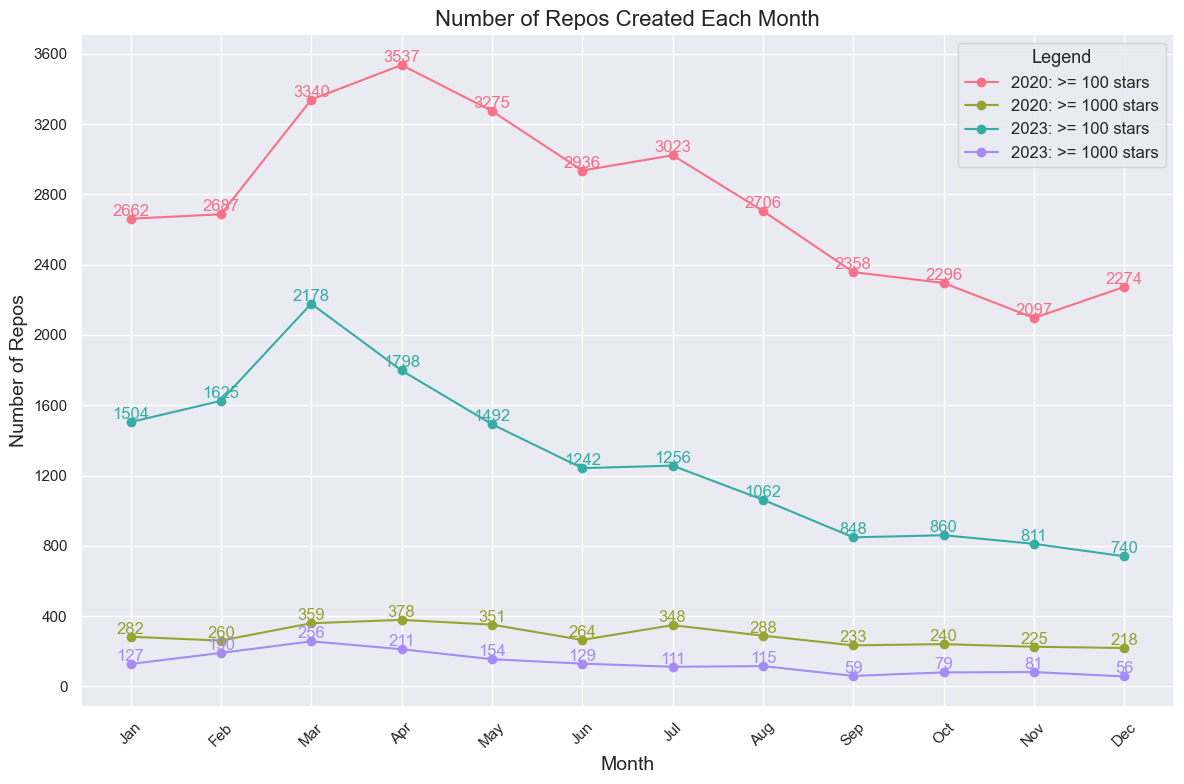

In [8]:
def plot_combined_monthly_repo_creation(repos_dfs, years, min_stars_list=[None]):
    """
    Plots the number of repositories created each month for multiple DataFrames with overlays for different minimum star counts.
    Displays the number of repositories at each point on the lines.
    
    Args:
    repos_dfs (list of DataFrame): List of DataFrames containing repository data.
    years (list of int): List of years corresponding to the DataFrames in repos_dfs.
    min_stars_list (list, optional): List of minimum star counts to overlay. Defaults to [None].
    """

    sns.set_theme(style="darkgrid")
    
    plt.figure(figsize=(12, 8))
    
    # Define a color palette
    colors = sns.color_palette("husl", len(min_stars_list) * len(repos_dfs))
    color_idx = 0  # Initialize color index
    
    # Loop through each DataFrame and each minimum star count
    for idx, (repos_df, year) in enumerate(zip(repos_dfs, years)):
        for min_stars in min_stars_list:
            # Filter DataFrame based on min_stars if specified
            if min_stars is not None:
                filtered_df = repos_df[repos_df['stargazers_count'] >= min_stars].copy()
            else:
                filtered_df = repos_df.copy()
            
            # Convert 'created_at' to datetime
            filtered_df['created_at'] = pd.to_datetime(filtered_df['created_at'])

            # Group by month and count the number of repos in each month
            monthly_counts = filtered_df.groupby(filtered_df['created_at'].dt.month).size()

            # Plotting
            plt.plot(range(1, 13), monthly_counts.values, label=f'{year}: >= {min_stars} stars' if min_stars is not None else f'{year}: All stars', color=colors[color_idx], marker='o', linestyle='-')
            
            # Annotate each point with the number of repos
            for month, count in enumerate(monthly_counts.values, start=1):
                plt.text(month, count, str(count), ha='center', va='bottom', color=colors[color_idx])
            
            color_idx += 1  # Increment color index for the next loop
    
    # Formatting the x-axis to show months as labels
    ax = plt.gca()  # Get the current Axes instance
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.xticks(rotation=45)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure y-axis labels are integer

    plt.title('Number of Repos Created Each Month', fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Number of Repos', fontsize=14)
    plt.legend(fontsize=12, title="Legend", title_fontsize='13')
    plt.tight_layout()
    
    # Optionally, adjust margins or padding here if needed
    plt.show()

plot_combined_monthly_repo_creation([repos_2020, repos_2023], [2020, 2023], [100, 1000])

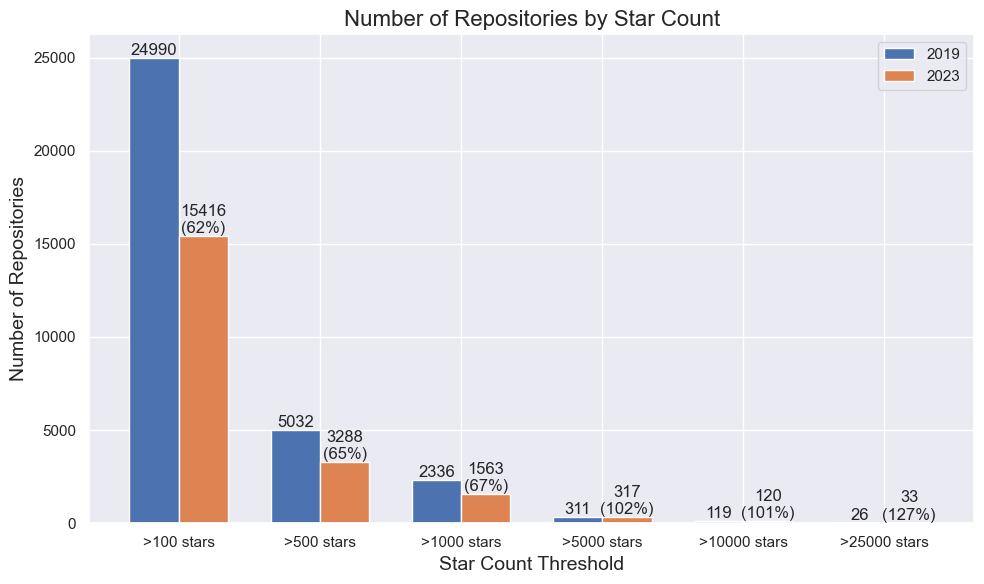

In [9]:
def plot_repo_stars_distribution(repos_df_1, repos_df_2, year_1, year_2, star_thresholds):
    """
    Plot the number of repositories based on star count thresholds for two DataFrame subsets and show the percentage increase.

    :param repos_df_1: DataFrame containing repository data for the first year
    :param repos_df_2: DataFrame containing repository data for the second year
    :param year_1: Year corresponding to repos_df_1
    :param year_2: Year corresponding to repos_df_2
    :param star_thresholds: List of star count thresholds to plot
    """
    # Ensure star_thresholds is a list
    if not isinstance(star_thresholds, list):
        raise ValueError("star_thresholds must be a list of integers")
    
    # Ensure both repos_df_1 and repos_df_2 are DataFrames
    if not isinstance(repos_df_1, pd.DataFrame) or not isinstance(repos_df_2, pd.DataFrame):
        raise ValueError("Both repos_df_1 and repos_df_2 must be pandas DataFrames")

    # Initialize lists to hold the counts for each threshold for each DataFrame
    star_counts_1 = []
    star_counts_2 = []

    # Calculate the number of repos for each star threshold for each DataFrame
    for threshold in star_thresholds:
        count_1 = repos_df_1[repos_df_1['stargazers_count'] > threshold].shape[0]
        count_2 = repos_df_2[repos_df_2['stargazers_count'] > threshold].shape[0]
        star_counts_1.append(count_1)
        star_counts_2.append(count_2)

    # Plotting
    plt.figure(figsize=(10, 6))
    bar_width = 0.35  # Width of bars to fit both repos_df bars in one threshold slot
    x_indexes = np.arange(len(star_thresholds))
    
    plt.bar(x_indexes - bar_width/2, star_counts_1, width=bar_width, label=f'{year_1}')
    plt.bar(x_indexes + bar_width/2, star_counts_2, width=bar_width, label=f'{year_2}')

    # Set the x-axis labels to the star thresholds, with appropriate formatting
    plt.xticks(x_indexes, [f'>{threshold} stars' for threshold in star_thresholds])

    # Annotate each bar with the count and percentage increase
    for i, (count_1, count_2) in enumerate(zip(star_counts_1, star_counts_2)):
        plt.text(i - bar_width/2, count_1, f'{count_1}', ha='center', va='bottom')
        if count_1 > 0:
            percentage_increase = f'({count_2/count_1:.0%})'
            plt.text(i + bar_width/2, count_2, f'{count_2}\n{percentage_increase}', ha='center', va='bottom')
        else:
            plt.text(i + bar_width/2, count_2, f'{count_2}\n(N/A)', ha='center', va='bottom')

    plt.title('Number of Repositories by Star Count', fontsize=16)
    plt.xlabel('Star Count Threshold', fontsize=14)
    plt.ylabel('Number of Repositories', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_repo_stars_distribution(repos_2021, repos_2023, 2019, 2023, [100, 500, 1000, 5000, 10000, 25000])

In [10]:
def print_top_repos_by_year_markdown(repos_dict, years, top_n=50):
    """
    Generates a Markdown table with columns for each year, where each column contains the star count and
    the name as a hyperlink of the top_n repositories with the most stars.

    :param repos_dict: Dictionary of DataFrames where keys are years and values are the DataFrames containing repository data
    :param years: List of years to include in the table
    :param top_n: Number of top repositories to display per year
    """
    # Initialize a list to store the data for the table
    table_data = []

    # Process each year
    for year in years:
        repos_df = repos_dict.get(year)
        if repos_df is not None:
            # Sort the DataFrame based on the 'stargazers_count' column in descending order
            sorted_repos = repos_df.sort_values(by='stargazers_count', ascending=False).head(top_n)

            # Extract relevant information and format it as a single string for the Markdown table
            year_data = [
                f"{row['stargazers_count']} stars - [{row['name']}]({row['html_url']})"
                for _, row in sorted_repos.iterrows()
            ]

            # If the year's data has fewer rows than top_n, pad with empty strings to maintain table structure
            if len(year_data) < top_n:
                year_data += [""] * (top_n - len(year_data))

            table_data.append(year_data)
        else:
            # If no data for the year, fill the column with empty strings
            table_data.append([""] * top_n)

    # Transpose the list of lists to fit the tabulate format (list of rows instead of list of columns)
    table_data_transposed = list(zip(*table_data))

    # Create headers based on the years
    headers = [f"{year}" for year in years]

    # Generate and print the Markdown table
    markdown_table = tabulate(table_data_transposed, headers=headers, tablefmt="pipe")
    print(markdown_table)


# Assuming repos_2022 and repos_2023 are pandas DataFrames for their respective years
repos_dict = {
    2019: repos_2019,
    2020: repos_2020,
    2021: repos_2021,
    2022: repos_2022,
    2023: repos_2023,
}
years = [2019, 2020, 2021, 2022, 2023]
print_top_repos_by_year_markdown(repos_dict, years, 25)

| 2019                                                                                               | 2020                                                                                                                                    | 2021                                                                                                | 2022                                                                                             | 2023                                                                                   |
|:---------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------|:---------------------------

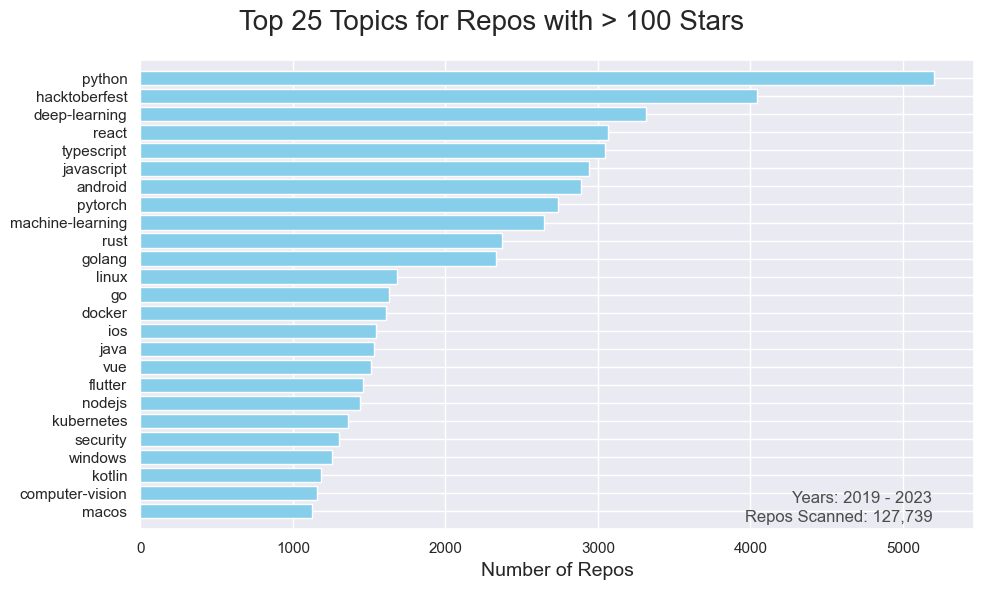

In [11]:
def plot_top_topics(repos_dfs, star_threshold, top_n=10, excluded_topics=None):
    """
    Plot the top N most popular topics for one or more repositories with stars greater than the given threshold, 
    excluding specified topics. Additionally, print the number of repos scanned and the years of the repositories on the chart.

    :param repos_dfs: A single DataFrame or a list of DataFrames containing repository data
    :param star_threshold: The minimum number of stars a repository must have
    :param top_n: The number of top topics to plot
    :param excluded_topics: A list of topics to exclude from the plot
    """
    
    # Ensure repos_dfs is a list even if a single DataFrame is passed
    if not isinstance(repos_dfs, list):
        repos_dfs = [repos_dfs]
    
    # Initialize a list to hold all topics from all DataFrames
    all_topics = []
    
    # Initialize a variable to keep track of the number of scanned repos
    num_scanned = 0
    
    # Initialize a set to keep track of the years of the repositories
    years_included = set()
    
    # Process each DataFrame
    for repos_df in repos_dfs:
        # Filter the DataFrame for repos with stars greater than the threshold
        filtered_repos = repos_df[repos_df['stargazers_count'] > star_threshold]
        num_scanned += len(filtered_repos)
        
        # Add the year of the current DataFrame to the years_included set
        years_included.update(pd.to_datetime(filtered_repos['created_at']).dt.year.unique())
        
        # Combine all topics into a single list, excluding the specified topics
        for topics in filtered_repos['topics']:
            all_topics.extend([topic for topic in topics if excluded_topics is None or topic not in excluded_topics])
    
    # Count the occurrences of each topic
    topic_counts = Counter(all_topics)
    
    # Get the top N topics
    top_topics = topic_counts.most_common(top_n)
    
    # Prepare data for plotting
    topics, counts = zip(*top_topics)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(topics)), counts, color='skyblue')
    plt.yticks(range(len(topics)), topics)
    plt.xlabel('Number of Repos', fontsize=14)
    plt.suptitle(f'Top {top_n} Topics for Repos with > {star_threshold} Stars', fontsize=20)

    start_year = min(years_included)
    end_year = max(years_included)
    plt.text(0.95, 0.05, f'Years: {start_year} - {end_year}', 
             verticalalignment='bottom', horizontalalignment='right',
             transform=plt.gca().transAxes, color=(0.3, 0.3, 0.3), fontsize=12)
    plt.text(0.95, 0.01, f'Repos Scanned: {num_scanned:,}', 
             verticalalignment='bottom', horizontalalignment='right',
             transform=plt.gca().transAxes, color=(0.3, 0.3, 0.3), fontsize=12)
    plt.ylim(-1, len(topics))
    plt.gca().invert_yaxis()  # Invert y-axis to have the topic with the highest count on top

    plt.tight_layout()
    plt.show()

plot_top_topics([repos_2019, repos_2020, repos_2021, repos_2022, repos_2023], 100, 25)

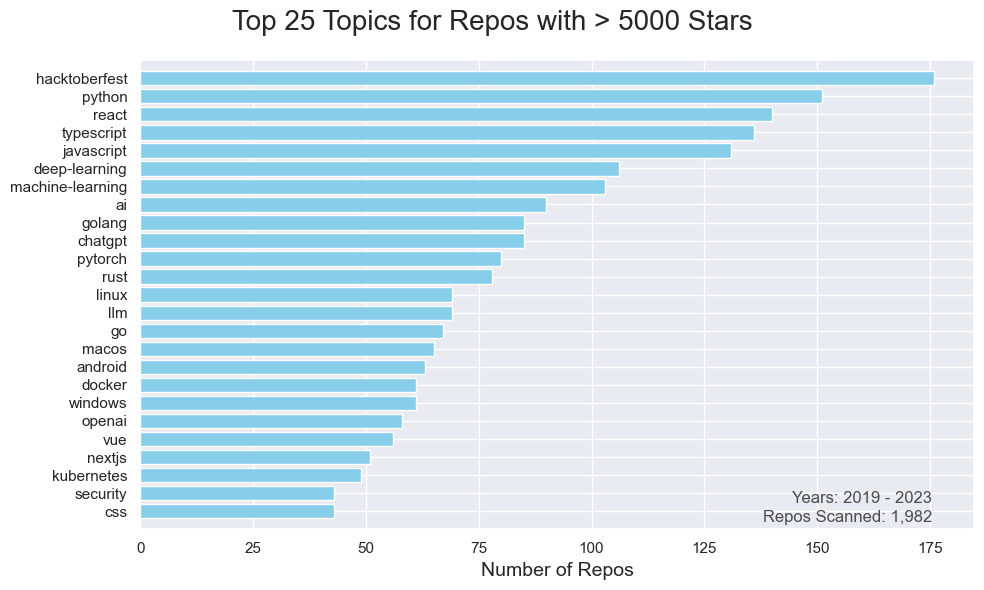

In [12]:
plot_top_topics([repos_2019, repos_2020, repos_2021, repos_2022, repos_2023], 5000, 25)

In [13]:
def count_repos_with_topics(years_dataframes, topics_list):
    """
    Counts the number of repositories that include all of the specified topics.
    
    Parameters:
    - years_dataframes: A list of tuples, each containing the year as a string and the corresponding DataFrame.
    - topics_list: A list of topics to check for in each repository's topics.
    
    Returns:
    A dictionary with the count of repositories for each topic list.
    """
    counts = {tuple(topics_list): 0}
    
    for year, repos_df in years_dataframes:
        # Count the number of repositories that include all the specified topics
        counts[tuple(topics_list)] += sum(all(topic in topics for topic in topics_list) for topics in repos_df['topics'])
    
    return counts

# Count repositories with 'javascript' topic across all years
javascript_count = count_repos_with_topics(years_dataframes, ['javascript'])
print(f"Total number of repos with a 'javascript' topic across all years: {javascript_count[('javascript',)]}")

# Count repositories with 'typescript' topic across all years
typescript_count = count_repos_with_topics(years_dataframes, ['typescript'])
print(f"Total number of repos with a 'typescript' topic across all years: {typescript_count[('typescript',)]}")

# Count repositories with both 'typescript' and 'javascript' topics across all years
typescript_javascript_count = count_repos_with_topics(years_dataframes, ['typescript', 'javascript'])
print(f"Total number of repos with both 'typescript' and 'javascript' topics across all years: {typescript_javascript_count[('typescript', 'javascript')]}")

Total number of repos with a 'javascript' topic across all years: 2941
Total number of repos with a 'typescript' topic across all years: 3046
Total number of repos with both 'typescript' and 'javascript' topics across all years: 791


In [14]:
def calculate_unique_topics(repos_dfs, year):
    # Calculate the total number of unique topics across all repositories in the given array of dataframes
    unique_topics = set()
    for repos_df in repos_dfs:
        for repo_topics in repos_df['topics']:
            unique_topics.update(repo_topics)
    total_unique_topics = len(unique_topics)
    print(f"Unique topics in {year}: {total_unique_topics}")

In [15]:
calculate_unique_topics([repos_2019, repos_2020, repos_2021, repos_2022, repos_2023], "totl")
calculate_unique_topics([repos_2019], 2019)
calculate_unique_topics([repos_2020], 2020)
calculate_unique_topics([repos_2021], 2021)
calculate_unique_topics([repos_2022], 2022)
calculate_unique_topics([repos_2023], 2023)

Unique topics in totl: 97666
Unique topics in 2019: 41184
Unique topics in 2020: 42476
Unique topics in 2021: 31516
Unique topics in 2022: 24881
Unique topics in 2023: 17561


In [16]:
def count_topic_specific_repos_with_star_threshold(dataframes, star_threshold, topic):
    """
    Prints the number of repositories with a specific topic and stars greater than or equal to the given threshold for each dataframe.
    
    Parameters:
    - dataframes: A list of tuples, where each tuple contains a year and the corresponding dataframe
    - star_threshold: The minimum number of stars a repository must have to be counted
    - topic: The topic that the repository must be tagged with
    """
    for year, repos_df in dataframes:
        count = repos_df[(repos_df['stargazers_count'] >= star_threshold) & (repos_df['topics'].apply(lambda topics: topic in topics))].shape[0]
        print(f"Number of repositories in {year} with topic '{topic}' and stars >= {star_threshold}: {count}")

star_threshold = 100
topic = 'llm'
count_topic_specific_repos_with_star_threshold(years_dataframes, star_threshold, topic)

Number of repositories in 2019 with topic 'llm' and stars >= 100: 10
Number of repositories in 2020 with topic 'llm' and stars >= 100: 8
Number of repositories in 2021 with topic 'llm' and stars >= 100: 15
Number of repositories in 2022 with topic 'llm' and stars >= 100: 52
Number of repositories in 2023 with topic 'llm' and stars >= 100: 663


In [17]:
def plot_top_exclusive_topics(repos_df1, repos_df2, year1, year2, top_n=10):
    """
    Plots the top-N topics that are present in repos_df1 but not in repos_df2.
    
    Parameters:
    - repos_df1: DataFrame containing repository data including topics for year1
    - repos_df2: DataFrame containing repository data including topics for year2
    - year1: The year corresponding to repos_df1
    - year2: The year corresponding to repos_df2
    - top_n: The number of top topics to display
    """
    # Calculate the unique topics in each dataframe
    unique_topics_df1 = set()
    for topics in repos_df1['topics']:
        unique_topics_df1.update(topics)
    
    unique_topics_df2 = set()
    for topics in repos_df2['topics']:
        unique_topics_df2.update(topics)
    
    # Find topics that are exclusive to repos_df1
    exclusive_topics = unique_topics_df1 - unique_topics_df2
    
    # Count the occurrences of each exclusive topic in repos_df1
    topic_counts = {topic: 0 for topic in exclusive_topics}
    for topics in repos_df1['topics']:
        for topic in topics:
            if topic in exclusive_topics:
                topic_counts[topic] += 1
    
    # Sort the topics by count and take the top N
    sorted_topics = sorted(topic_counts.items(), key=lambda item: item[1], reverse=True)
    top_topics = sorted_topics[:top_n]
    
    # Plotting
    topics, counts = zip(*top_topics)
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(topics)), counts, color='skyblue')
    plt.yticks(range(len(topics)), topics)
    plt.xlabel('Number of Repositories', fontsize=14)
    plt.title(f'Top {top_n} Topics in {year1} but not in {year2}', fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis to have the topic with the highest count on top
    plt.tight_layout()
    plt.show()

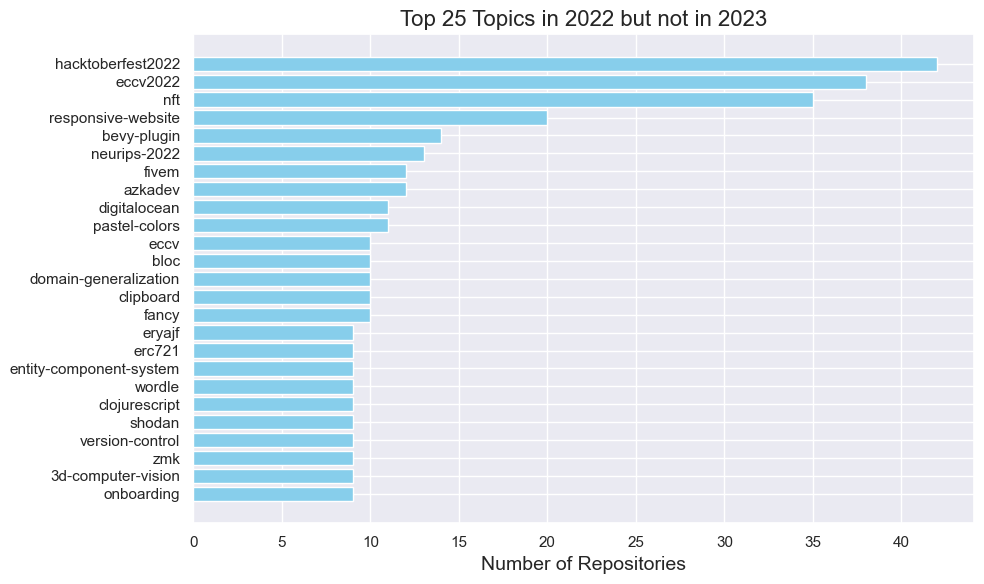

In [18]:
plot_top_exclusive_topics(repos_2022, repos_2023, 2022, 2023, top_n=25)

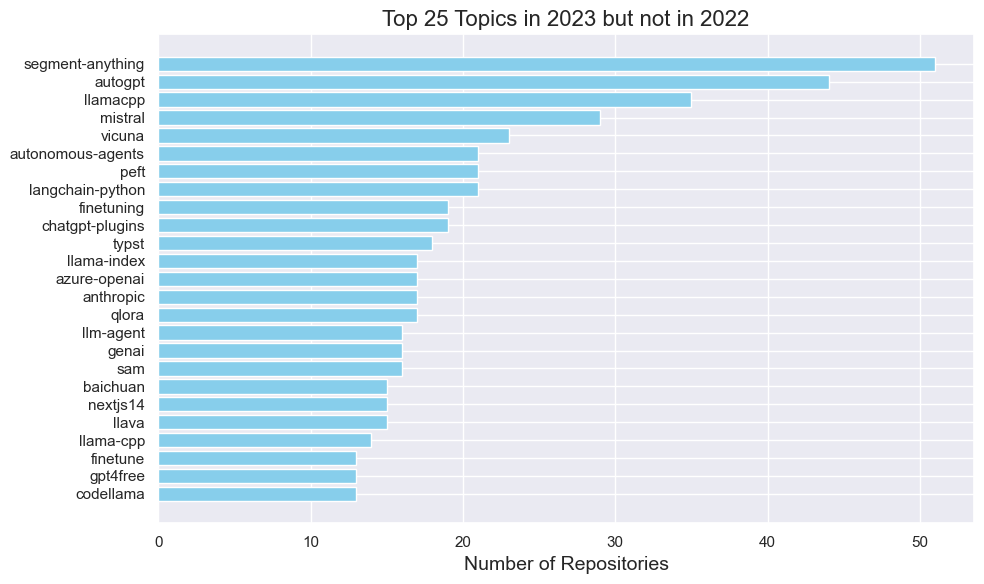

In [19]:
plot_top_exclusive_topics(repos_2023, repos_2022, 2023, 2022, top_n=25)

In [20]:
def plot_top_topics_comparison(repos_df1, repos_df2, year_1, year_2, top_n=10):
    """
    Plot the top N topics for repos_df1 and their counts in repos_df2, including the total number of repositories.
    
    Parameters:
    - repos_df1: DataFrame containing repository data including topics
    - repos_df2: DataFrame containing repository data including topics
    - year_1: The year corresponding to repos_df1
    - year_2: The year corresponding to repos_df2
    - top_n: The number of top topics to display
    """
    # Calculate the unique topics in each dataframe
    unique_topics_df1 = set()
    for topics in repos_df1['topics']:
        unique_topics_df1.update(topics)

    # Count the occurrences of each topic in repos_df1
    topic_counts_df1 = {topic: 0 for topic in unique_topics_df1}
    for topics in repos_df1['topics']:
        for topic in topics:
            topic_counts_df1[topic] += 1

    # Count the occurrences of each topic in repos_df2
    topic_counts_df2 = {topic: 0 for topic in unique_topics_df1}
    for topics in repos_df2['topics']:
        for topic in topics:
            if topic in topic_counts_df2:
                topic_counts_df2[topic] += 1

    # Sort the topics by count in repos_df1 and take the top N
    sorted_topics_df1 = sorted(topic_counts_df1.items(), key=lambda item: item[1], reverse=True)
    top_topics_df1 = sorted_topics_df1[:top_n]

    # Extract the counts for the same topics in repos_df2
    top_topics_df2_counts = [topic_counts_df2[topic] for topic, _ in top_topics_df1]

    # Plotting
    topics, counts_df1 = zip(*top_topics_df1)
    plt.figure(figsize=(10, 6))
    bar_width = 0.4
    index = np.arange(len(topics))

    bar1 = plt.barh(index, counts_df1, bar_width, color='skyblue', label=f'{year_1} (Total repos: {len(repos_df1)})')
    bar2 = plt.barh(index + bar_width, top_topics_df2_counts, bar_width, color='lightcoral', label=f'{year_2} (Total repos: {len(repos_df2)})')

    plt.yticks(index + bar_width / 2, topics)
    plt.xlabel('Number of Repositories', fontsize=14)
    plt.title(f'Top {top_n} Topics in {year_1} and their counts in {year_2}', fontsize=16)
    plt.legend()
    plt.gca().invert_yaxis()  # Invert y-axis to have the topic with the highest count on top
    plt.tight_layout()
    plt.show()

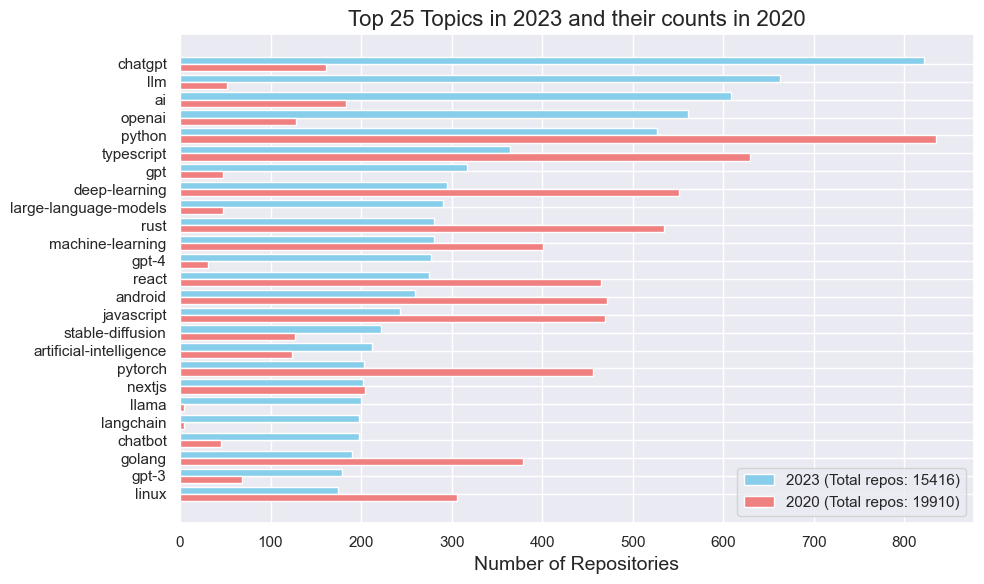

In [21]:
plot_top_topics_comparison(repos_2023, repos_2022, 2023, 2020, 25)

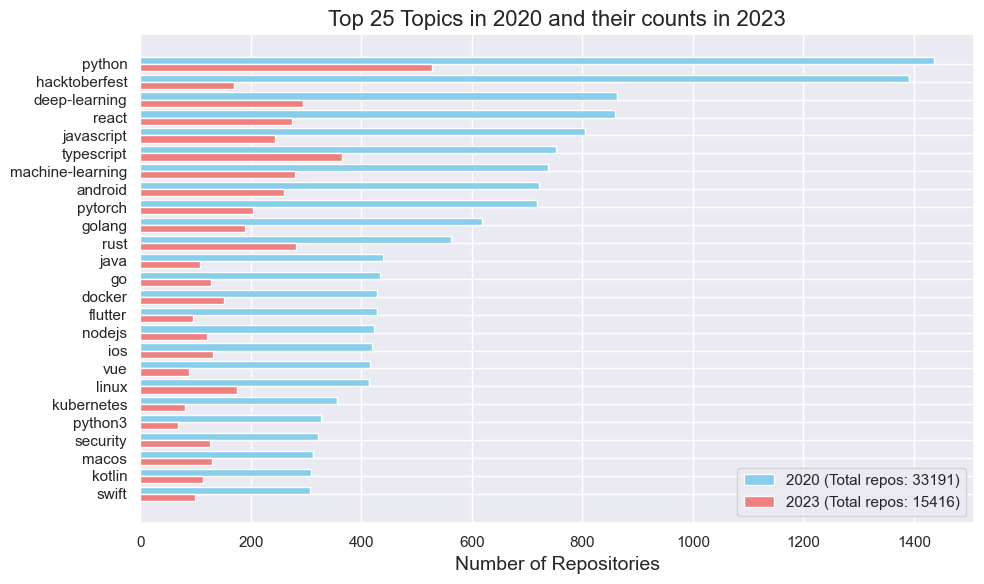

In [22]:
plot_top_topics_comparison(repos_2020, repos_2023, 2020, 2023, 25)

In [23]:
def plot_selected_topics_comparison_percent(repos_df1, repos_df2, year_1, year_2, selected_topics):
    """
    Plot the selected topics for repos_df1 and their percentages in repos_df2.
    
    Parameters:
    - repos_df1: DataFrame containing repository data including topics
    - repos_df2: DataFrame containing repository data including topics
    - year_1: The year corresponding to repos_df1
    - year_2: The year corresponding to repos_df2
    - selected_topics: The list of topics to display
    """
    # Count the occurrences of each topic in repos_df1
    topic_counts_df1 = {topic: 0 for topic in selected_topics}
    total_repos_df1 = len(repos_df1)
    for topics in repos_df1['topics']:
        for topic in topics:
            if topic in topic_counts_df1:
                topic_counts_df1[topic] += 1

    # Convert counts to percentages for repos_df1
    topic_percentages_df1 = {topic: (count / total_repos_df1) * 100 for topic, count in topic_counts_df1.items()}

    # Count the occurrences of each topic in repos_df2
    topic_counts_df2 = {topic: 0 for topic in selected_topics}
    total_repos_df2 = len(repos_df2)
    for topics in repos_df2['topics']:
        for topic in topics:
            if topic in topic_counts_df2:
                topic_counts_df2[topic] += 1

    # Convert counts to percentages for repos_df2
    topic_percentages_df2 = {topic: (count / total_repos_df2) * 100 for topic, count in topic_counts_df2.items()}

    # Extract the percentages for the selected topics
    selected_topics_percentages_df1 = [topic_percentages_df1[topic] for topic in selected_topics]
    selected_topics_percentages_df2 = [topic_percentages_df2[topic] for topic in selected_topics]

    # Plotting
    plt.figure(figsize=(10, 6))
    bar_width = 0.4
    index = np.arange(len(selected_topics))

    bar1 = plt.barh(index, selected_topics_percentages_df1, bar_width, color='skyblue', label=f'{year_1} Repositories (%)')
    bar2 = plt.barh(index + bar_width, selected_topics_percentages_df2, bar_width, color='lightcoral', label=f'{year_2} Repositories (%)')

    plt.yticks(index + bar_width / 2, selected_topics)
    plt.xlabel('Percentage of Repositories', fontsize=14)
    plt.title(f'Selected Topics in {year_1} and Their Percentages in {year_2}', fontsize=16)
    plt.legend()
    plt.gca().invert_yaxis()  # Invert y-axis to have the topic with the highest percentage on top
    plt.tight_layout()
    plt.show()

In [24]:
def get_top_n_topics(repos_df, top_N):
    """
    Returns a list of the top N topics across all repositories in the given DataFrame.

    :param repos_df: DataFrame containing repository data with a 'topics' column
    :param top_N: The number of top topics to return
    :return: List of top N topics
    """
    # Flatten the list of topics from all repositories and count occurrences
    all_topics = [topic for topics_list in repos_df['topics'] for topic in topics_list]
    topic_counts = Counter(all_topics)
    # Get the most common topics up to the top N
    top_topics = topic_counts.most_common(top_N)
    
    # Return only the topic names, not the counts
    return [topic for topic, count in top_topics]

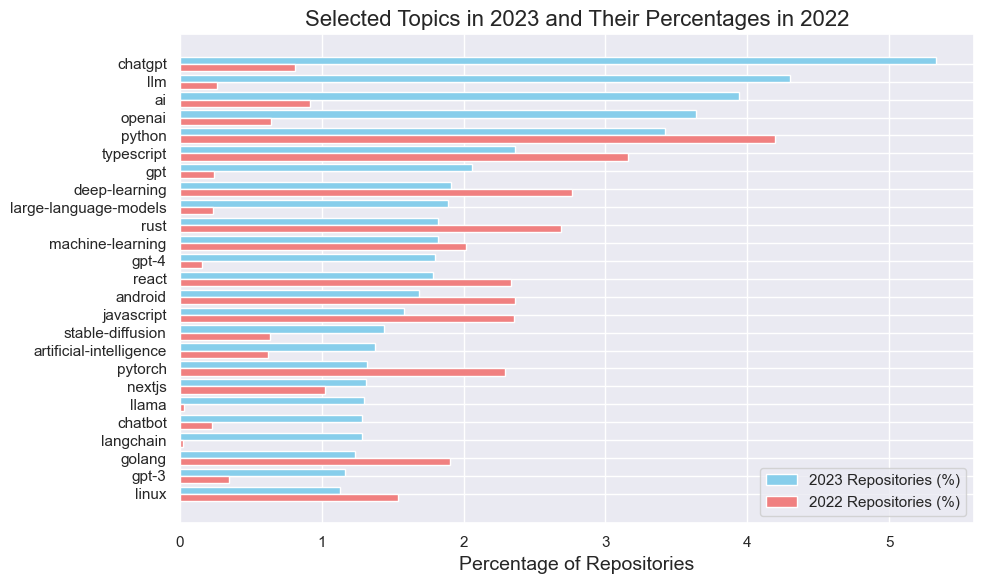

In [25]:
plot_selected_topics_comparison_percent(repos_2023, repos_2022, 2023, 2022, get_top_n_topics(repos_2023, 25))

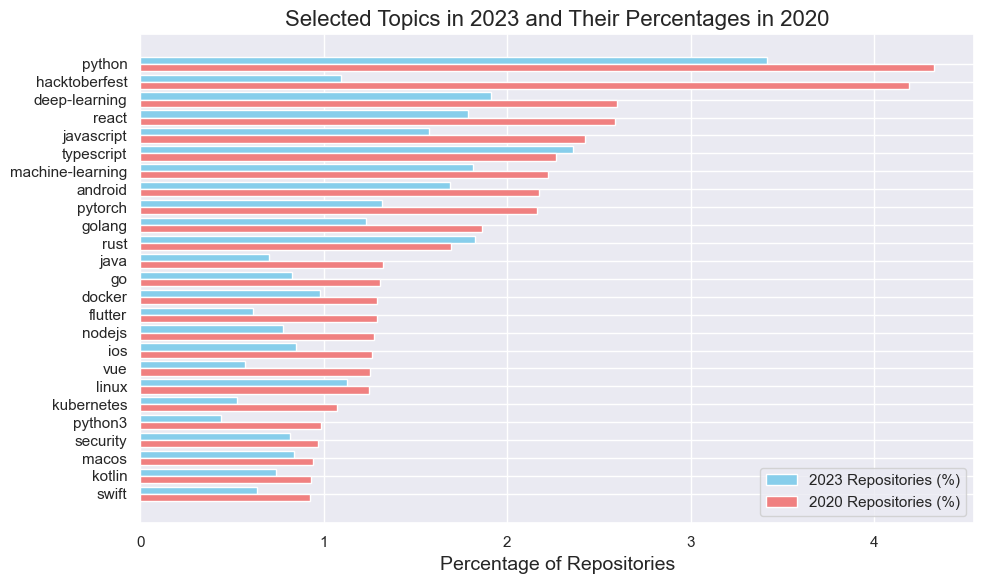

In [26]:
plot_selected_topics_comparison_percent(repos_2023, repos_2020, 2023, 2020, get_top_n_topics(repos_2020, 25))

In [27]:
programming_languages = [
    'typescript', 'python', 'rust', 'go', 'golang', 'javascript', 'java', 'cpp', 'csharp', 'swift', 'kotlin', 'php', 'ruby', 'c', 'lua', 'bash', 'powershell', 'dart'
]

ai_technologies = [
    'llm', 'ai', 'chatgpt', 'openai', 'gpt', 'machine-learning', 'large-language-models', 'artificial-intelligence', 'deep-learning', 'generative-ai', 'nlp', 'transformers', 'gpt-3', 'gpt-4', 'llm-inference', 'rlhf', 'chatglm', 'gpt4', 'instruction-tuning', 'language-model', 'multimodal-large-language-models', 'large-vision-language-model', 'mixture-of-experts', 'diffusion-models', 'tensorrt-llm', 'llm-agent', 'llm-framework', 'vllm', 'chatbot', 'langchain', 'llama', 'llama2', 'stable-diffusion', 'prompt-engineering', 'rag'
]

combined_topics = programming_languages + ai_technologies

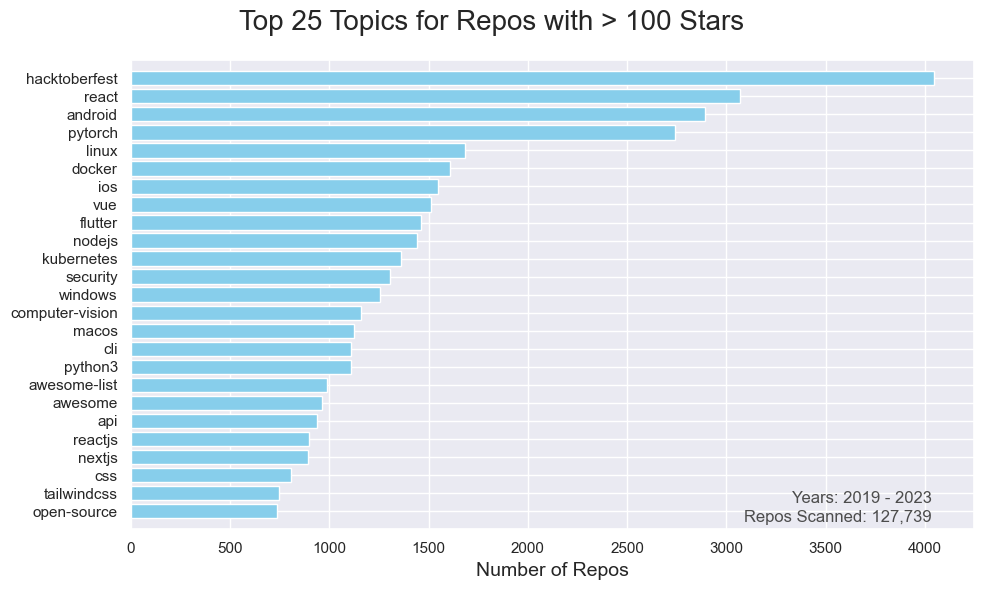

In [28]:
plot_top_topics([repos_2019, repos_2020, repos_2021, repos_2022, repos_2023], 100, 25, combined_topics)

In [29]:
def plot_selected_topics_comparison_percent_active_inactive(repos_df1, repos_df2, year_1, year_2, selected_topics):
    """
    Plot the selected topics for repos_df1 and their percentages in repos_df2, showing the active vs inactive repos.
    
    Parameters:
    - repos_df1: DataFrame containing repository data including topics and 'active' status
    - repos_df2: DataFrame containing repository data including topics and 'active' status
    - year_1: The year corresponding to repos_df1
    - year_2: The year corresponding to repos_df2
    - selected_topics: The list of topics to display
    """
    def calculate_topic_percentages(repos_df, selected_topics):
        topic_active_counts = {topic: 0 for topic in selected_topics}
        topic_inactive_counts = {topic: 0 for topic in selected_topics}
        total_repos = len(repos_df)
        
        for _, row in repos_df.iterrows():
            days_since_last_commit = row['since_commit']
            for topic in row['topics']:
                if topic in selected_topics:
                    if days_since_last_commit <= 60:
                        topic_active_counts[topic] += 1
                    else:
                        topic_inactive_counts[topic] += 1
        
        topic_percentages = {
            topic: {
                'active': (topic_active_counts[topic] / total_repos) * 100,
                'inactive': (topic_inactive_counts[topic] / total_repos) * 100
            }
            for topic in selected_topics
        }
        return topic_percentages

    topic_percentages_df1 = calculate_topic_percentages(repos_df1, selected_topics)
    topic_percentages_df2 = calculate_topic_percentages(repos_df2, selected_topics)

    # Plotting
    plt.figure(figsize=(10, 12))
    bar_width = 0.35
    index = np.arange(len(selected_topics))

    for i, topic in enumerate(selected_topics):
        active_percentage_df1 = topic_percentages_df1[topic]['active']
        inactive_percentage_df1 = topic_percentages_df1[topic]['inactive']
        active_percentage_df2 = topic_percentages_df2[topic]['active']
        inactive_percentage_df2 = topic_percentages_df2[topic]['inactive']

        plt.barh(index[i], active_percentage_df1, bar_width, color='darkblue', edgecolor='black', hatch='//')
        plt.barh(index[i], inactive_percentage_df1, bar_width, left=active_percentage_df1, color='none', edgecolor='black', hatch='//')
        plt.barh(index[i] + bar_width, active_percentage_df2, bar_width, color='orange', edgecolor='black', hatch='//')
        plt.barh(index[i] + bar_width, inactive_percentage_df2, bar_width, left=active_percentage_df2, color='none', edgecolor='black', hatch='//')

    plt.yticks(index + bar_width / 2, selected_topics)
    plt.xlabel('Percentage of Repositories', fontsize=14)
    plt.title(f'Selected Topics in {year_1} and their percentages in {year_2} (Active vs Inactive)', fontsize=16)
    plt.legend(['Active', 'Inactive'], loc='best')
    plt.gca().invert_yaxis()  # Invert y-axis to have the topic with the highest percentage on top
    plt.tight_layout()
    plt.show()

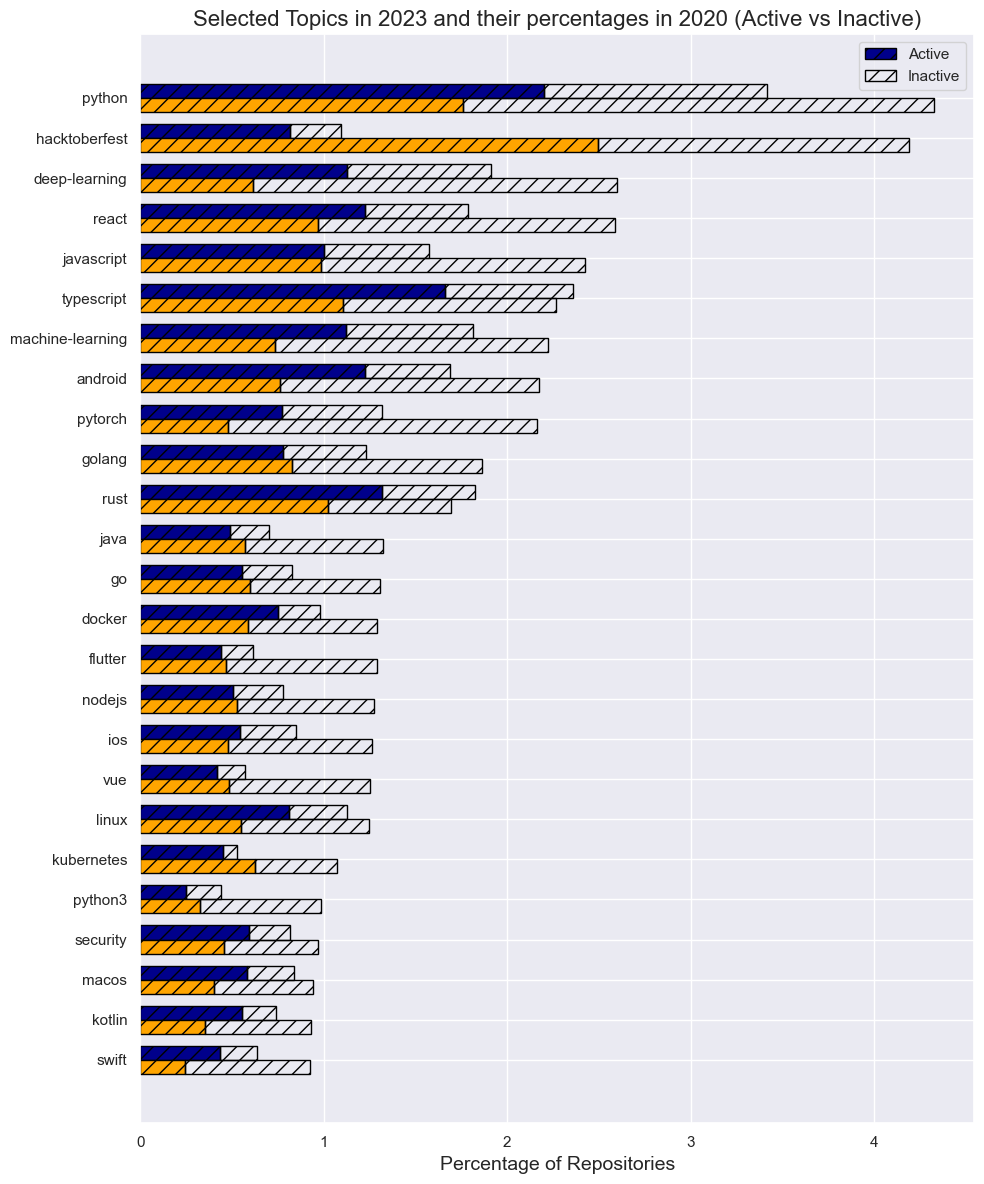

In [30]:
plot_selected_topics_comparison_percent_active_inactive(repos_2023, repos_2020, 2023, 2020, get_top_n_topics(repos_2020, 25))

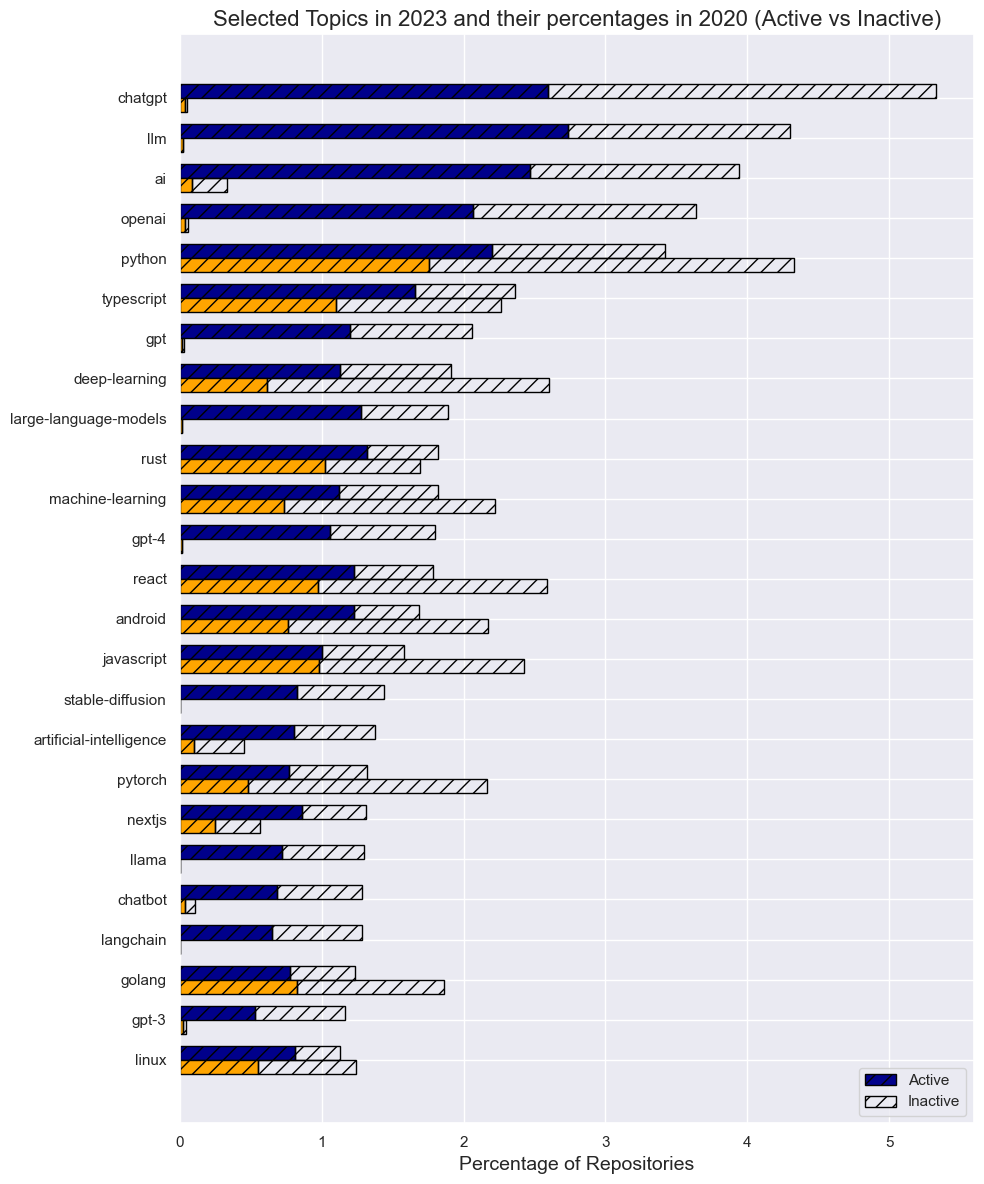

In [31]:
plot_selected_topics_comparison_percent_active_inactive(repos_2023, repos_2020, 2023, 2020, get_top_n_topics(repos_2023, 25))

In [32]:
def plot_top_n_topics_percent_active_inactive(repos_df, year, top_n, inactivity_days=30, min_stars=None):
    """
    Plot the top-N topics for repos_df, showing the active vs inactive repos, with optional filtering by star count.
    
    Parameters:
    - repos_df: DataFrame containing repository data including topics, 'active' status, and star count
    - year: The year corresponding to repos_df
    - top_n: The number of top topics to display
    - inactivity_days: The number of days to consider a repository inactive if no commits since
    - min_stars: The minimum number of stars a repository must have to be included
    """
    def calculate_topic_percentages(repos_df, top_n, min_stars):
        topic_counts = {}
        for _, row in repos_df.iterrows():
            if min_stars is None or row['stargazers_count'] >= min_stars:
                for topic in row['topics']:
                    if topic not in topic_counts:
                        topic_counts[topic] = {'active': 0, 'inactive': 0}
                    if row['since_commit'] <= inactivity_days:
                        topic_counts[topic]['active'] += 1
                    else:
                        topic_counts[topic]['inactive'] += 1
        
        # Sort topics by total counts and select top_n topics
        sorted_topics = sorted(topic_counts.items(), key=lambda item: item[1]['active'] + item[1]['inactive'], reverse=True)
        top_topics = sorted_topics[:top_n]
        
        total_repos = len(repos_df[repos_df['stargazers_count'] >= min_stars] if min_stars is not None else repos_df)
        topic_percentages = {
            topic: {
                'active': (counts['active'] / total_repos) * 100 if total_repos > 0 else 0,
                'inactive': (counts['inactive'] / total_repos) * 100 if total_repos > 0 else 0
            }
            for topic, counts in top_topics
        }
        return topic_percentages, [topic for topic, _ in top_topics]

    topic_percentages, top_topics = calculate_topic_percentages(repos_df, top_n, min_stars)

    # Plotting
    plt.figure(figsize=(12, 10))
    bar_width = 0.50
    index = np.arange(len(top_topics))

    for i, topic in enumerate(top_topics):
        active_percentage = topic_percentages[topic]['active']
        inactive_percentage = topic_percentages[topic]['inactive']

        percent_active_over_all_repos = active_percentage/(active_percentage + inactive_percentage) * 100 if (active_percentage + inactive_percentage) > 0 else 0

        plt.barh(index[i], active_percentage, bar_width, color='skyblue', edgecolor='black', label='Active' if i == 0 else "")
        plt.barh(index[i], inactive_percentage, bar_width, left=active_percentage, color='lightcoral', edgecolor='black', label=f'Inactive (> {inactivity_days} days)' if i == 0 else "")
        plt.text(active_percentage + inactive_percentage + .05, index[i], f"{percent_active_over_all_repos:.2f}%", va='center', ha='left')
        plt.yticks(index, top_topics)
    plt.xlabel('Percentage of Repositories', fontsize=14)
    plt.title(f'Top {top_n} Topics in {year} (Active vs Inactive > {inactivity_days} days)' + (f' with at least {min_stars} stars' if min_stars is not None else ''), fontsize=16)
    plt.legend(loc='best')
    plt.gca().invert_yaxis()  # Invert y-axis to have the topic with the highest percentage on top
    plt.tight_layout()
    plt.show()

In [33]:
def search_repos_with_topic(repos_df, topic):
    """
    Search for the number of repositories with a given topic.

    Parameters:
    - repos_df (DataFrame): The DataFrame containing repository data.
    - topic (str): The topic to search for.

    Returns:
    int: The number of repositories with the given topic.
    """
    # Filter the DataFrame for rows where the 'topics' column contains the specified topic
    repos_with_topic = repos_df[repos_df['topics'].apply(lambda topics: topic in topics)]
    return len(repos_with_topic)

In [34]:
# just to sanity check the function above
search_repos_with_topic(repos_2023, "python")/len(repos_2023)

0.034185262065386614

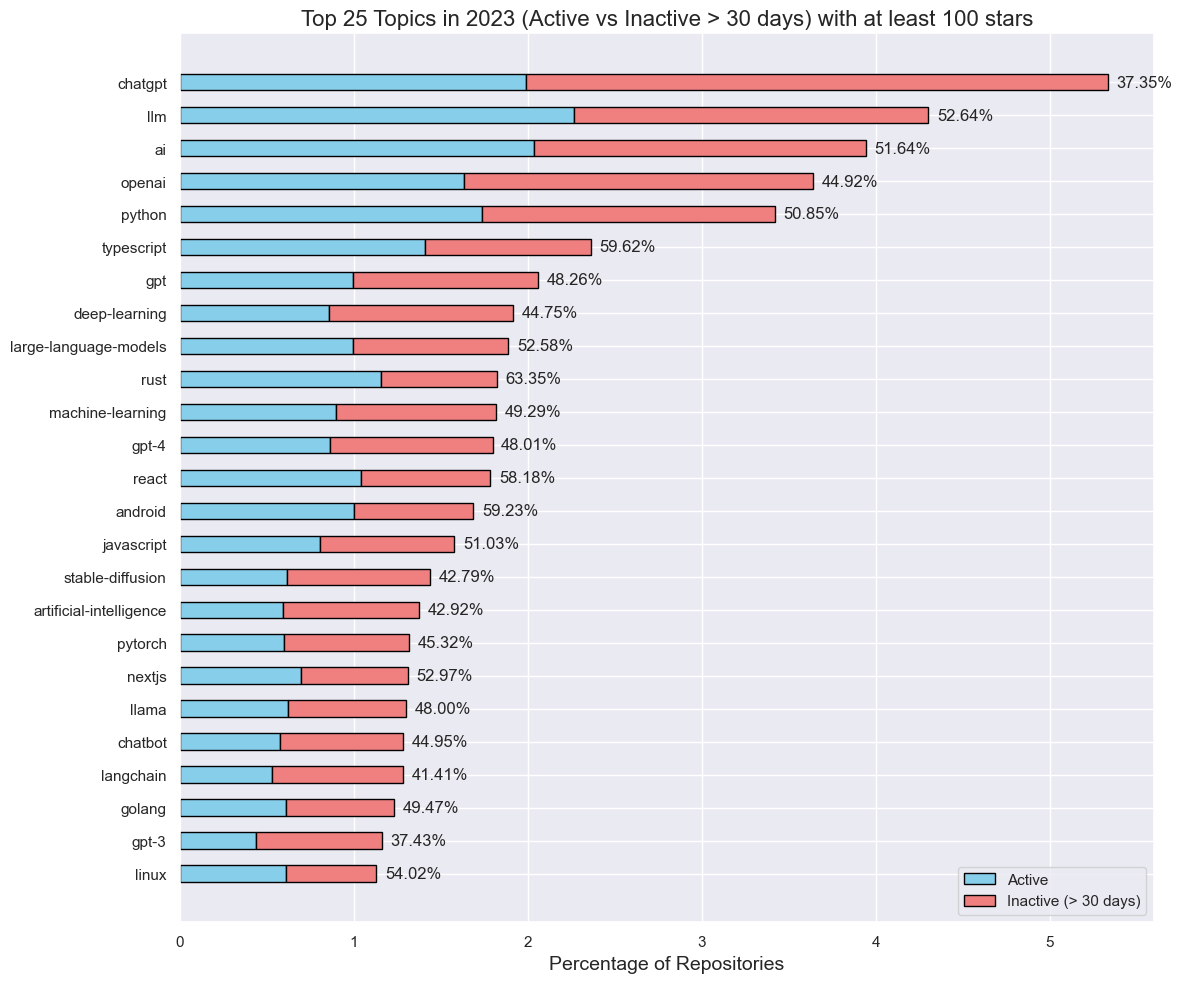

In [35]:
plot_top_n_topics_percent_active_inactive(repos_2023, 2023, 25, 30, 100)

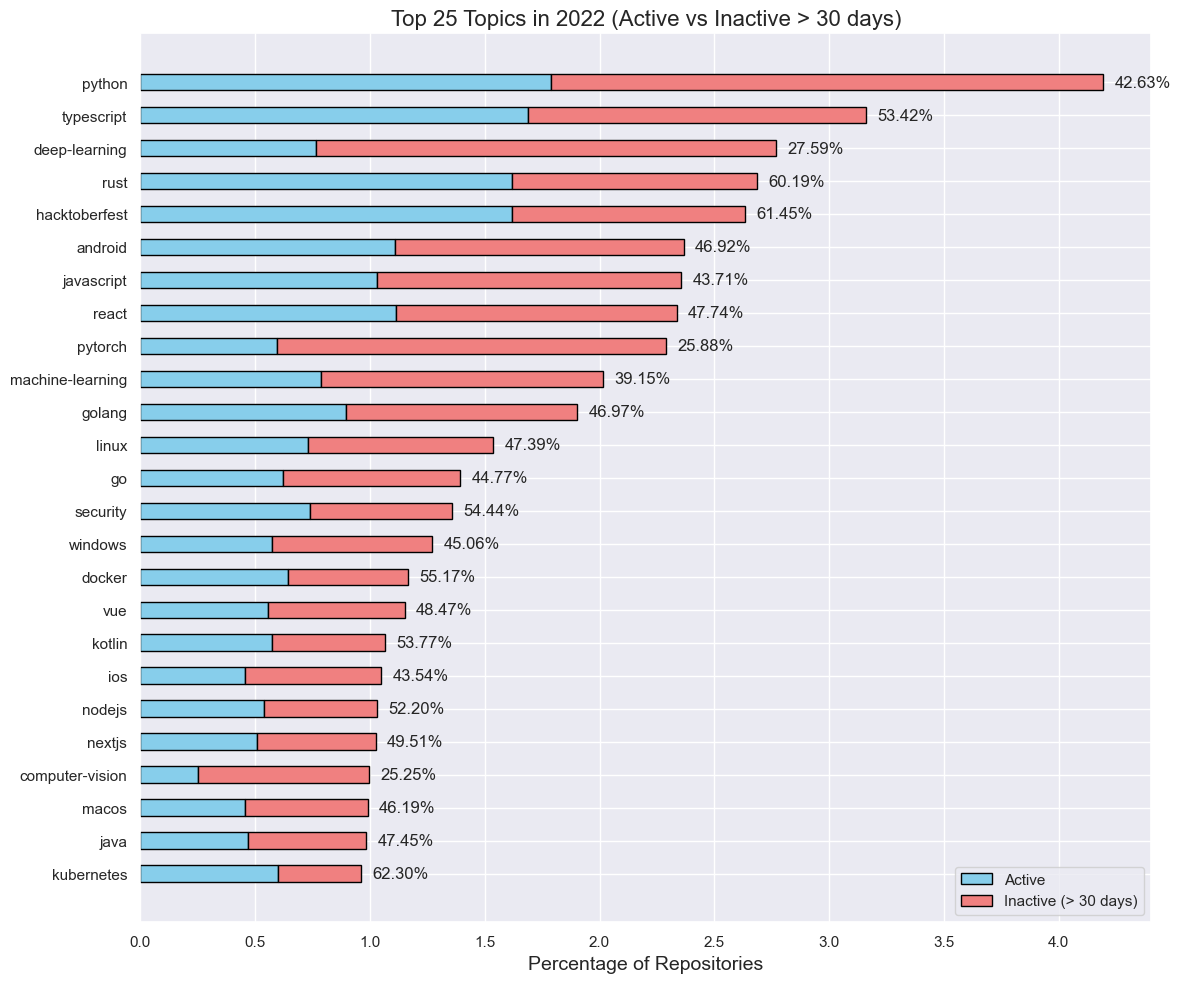

In [36]:
plot_top_n_topics_percent_active_inactive(repos_2022, 2022, 25)

In [37]:
def count_active_inactive_repos_by_topic(repos_df, topic, N=30):
    """
    Counts the number of active and inactive repositories with a specific topic.

    Parameters:
    - repos_df (DataFrame): The DataFrame containing repository data.
    - topic (str): The topic to search for.
    - N (int): The number of days to consider a repository inactive if no commits since.

    Prints:
    - The number of active and inactive repositories with the given topic.
    """
    # Filter the DataFrame for rows where the 'topics' column contains the specified topic
    repos_with_topic = repos_df[repos_df['topics'].apply(lambda topics: topic in topics)]
    
    # Determine active and inactive repositories
    active_repos = repos_with_topic[repos_with_topic['since_commit'] <= N]
    inactive_repos = repos_with_topic[repos_with_topic['since_commit'] > N]
    
    total_repos = len(active_repos) + len(inactive_repos)
    print(f"Active repositories with topic '{topic}': {len(active_repos)}")
    print(f"Inactive repositories with topic '{topic}': {len(inactive_repos)}")
    print((len(active_repos) / total_repos) * 100)
    

# Another quick sanity check on above
count_active_inactive_repos_by_topic(repos_2023, 'chatgpt')

Active repositories with topic 'chatgpt': 307
Inactive repositories with topic 'chatgpt': 515
37.34793187347932


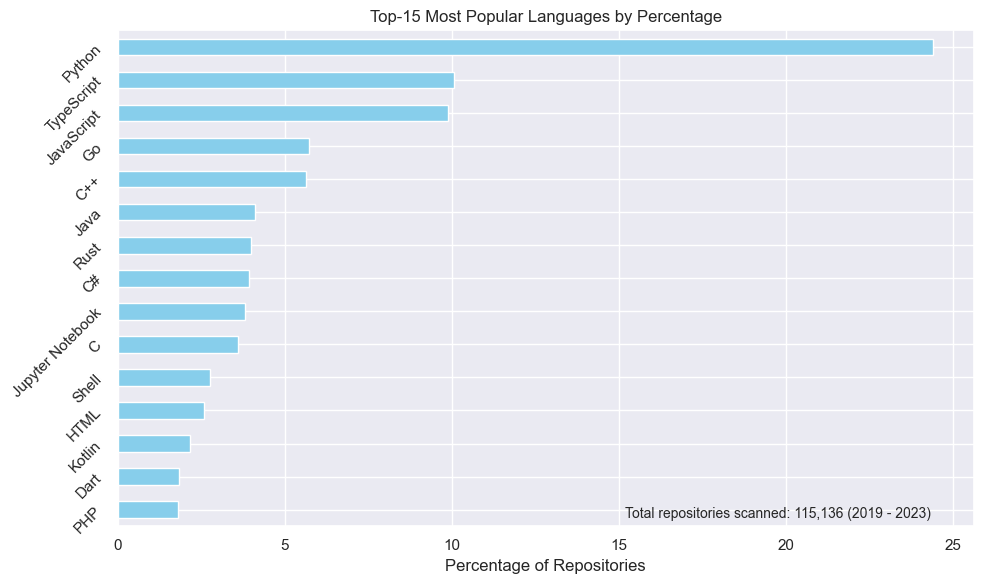

In [38]:
def plot_top_n_languages(repos_dfs, n=10):
    """
    Plots the top-N most popular languages by percentage across multiple DataFrames of repositories.

    Parameters:
    - repos_dfs (list of DataFrame): A list of DataFrames containing repository data.
    - n (int): The number of top languages to plot.
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # Accumulate language counts across all provided DataFrames
    language_counts = pd.Series(dtype=int)
    years = []  # List to store the years represented in the DataFrames
    for repos_df in repos_dfs:
        language_counts = language_counts.add(repos_df['language'].value_counts(), fill_value=0)
        years.append(pd.to_datetime(repos_df['created_at']).dt.year.iloc[0])  # Extracting the year from the 'created_at' timestamp
    # Get the top N languages
    top_language_counts = language_counts.nlargest(n)
    total_repos_scanned = language_counts.sum()
    
    # Calculate the percentage of each language
    language_percentages = (top_language_counts / total_repos_scanned) * 100
    
    # Plot the results with the highest percentage at the top
    plt.figure(figsize=(10, 6))
    language_percentages.sort_values(ascending=True).plot(kind='barh', color='skyblue')
    plt.title(f'Top-{n} Most Popular Languages by Percentage')
    plt.xlabel('Percentage of Repositories')
    plt.ylabel('') # print the old ylabel if this is removed. Cache issue?
    plt.yticks(rotation=45)
    
    plt.text(0.95, 0.01, f'Total repositories scanned: {int(total_repos_scanned):,} ({min(years)} - {max(years)})', 
             verticalalignment='bottom', horizontalalignment='right',
             transform=plt.gca().transAxes, fontsize=10)
    
    plt.tight_layout()
    plt.show()

plot_top_n_languages([repos_2019, repos_2020, repos_2021, repos_2022, repos_2023], 15)